<a href="https://colab.research.google.com/github/Elignesin/SureStart/blob/main/Feb25_AirlineTweetSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Airline Tweet Sentiment NN
This notebook will be used to build and train a basic neural network using Keras to analyze tweet sentiment for tweets about airlines. The goal of this activity is to explore regularization techniques used to avoid overfitting. The activity is taken from https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e#, and the data is taken from https://www.kaggle.com/crowdflower/twitter-airline-sentiment.

In [9]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import re
import collections 
import matplotlib.pyplot as plt
from pathlib import Path
#NLP Processing libraries
from sklearn.model_selection import train_test_split as tts
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
#Modeling packages
import tensorflow as tf
from tensorflow import keras
import keras
from keras import models, layers, regularizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#We need to encode some constants here
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

In [4]:
#The article then uses a bunch of "helper functions"
#The only change I made here was making the model verbose because I like the printout

def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history

def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results
    
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [10]:
#First we have to download the data from the csv
data = pd.read_csv('Tweets.csv')
#We'll also reindex the data so it's in a random order (shuffle it)
data = data.reindex(np.random.permutation(data.index))
#Now we want to keep only the text column and the sentiment column
data = data[['text', 'airline_sentiment']]
#Then, we'll apply our stopwords and mentions functions to clean our text
data.text = data.text.apply(remove_stopwords).apply(remove_mentions)

In [11]:
#How big is our dataset currently?
print(data.shape)

(14640, 2)


In [12]:
#Now we split out our test dataset (they use 10%, I'm going to use 15%)
X_train, X_test, y_train, y_test = tts(data['text'], data['airline_sentiment'],
                                      test_size = .15, random_state = 1693)

In [13]:
#Now we have to preprocess our text data
#This has two steps: Tokenizing and vectorizing

#First, we tokenize by getting rid of filters, making words lowercase, and splitting words
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

#Next, we convert to vectors using texts_to_matrix with mode=binary
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

#We also need to encode the target classes, which we'll do using a Label Encoder and one_hot_encoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [14]:
#Finally, we will split off our training data from our validation data
#Again, I'm using 15% here, rather than 10%
X_trainf, X_val, y_trainf, y_val = tts(X_train_oh, y_train_oh, test_size=.15,
                                       random_state = 1693)

In [17]:
#Now, we're going to build a very overfit  base model
#We use a softmax output layer because we have 3 classes encoded here
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

sequential_2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
21/21 [==============================] - 2s 74ms/step - loss: 0.9458 - accuracy: 0.5611 - val_loss: 0.7085 - val_accuracy: 0.6829
Epoch 2/20
21/21 [==============================] - 1s 51ms/step - loss: 0.6215 - accuracy: 0.7396 - val_loss: 0.5778 - val_accuracy: 0.7777
Epoch 3/20
21/21 [==============================] - 1s 52ms/step - loss: 0.4371 - accuracy: 0.8540 - val_loss: 0.5313 - val_accuracy: 0.7943
Epoch 4/20
21/21 [==============================] - 1s 51ms/step - loss: 0.3310 - accuracy: 0.8925 - val_loss: 0.5341 - val_accuracy: 0.7879
Epoch 5/20
21/21 [==============================] - 1s 51ms/step - loss: 0.2652 - accuracy: 0.9073 - val_loss: 0.5561 - val_accuracy: 0.7884
Epoch 6/20
21/21 [==============================] - 1s 50ms/step - loss: 0.2192 - accuracy: 0.9250 - val_loss: 0.5974 - val_accuracy: 0.7777
Epoch 7/20
21/21 [==============================] - 1s 50ms/step - loss: 0.1822 - accuracy: 0.9385 - val_loss: 0.6440 - val_accuracy: 0.7793
Epoch 8/20
21

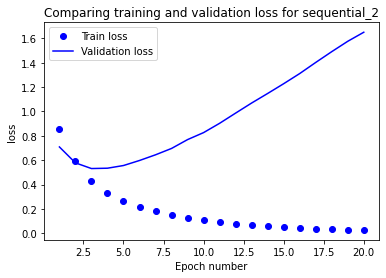

In [18]:
#Now, we will train and evaluate the model using the functions built earlier
base_history = deep_model(base_model, X_trainf, y_trainf, X_val, y_val)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

From the above, we can clearly see that the model is overfit.  
The training loss keeps improving towards 0, but the validation loss quickly increases instead (indicating the model is fit only to the training data).  

We will now consider 3 different methods to avoid overfitting.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 51        
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
21/21 [==============================] - 1s 46ms/step - loss: 1.0229 - accuracy: 0.5820 - val_loss: 0.8907 - val_accuracy: 0.6331
Epoch 2/20
21/21 [==============================] - 1s 31ms/step - loss: 0.8496 - accuracy: 0.6419 - val_loss: 0.7962 - val_accuracy: 0.6663
Epoch 3/20
21/21 [==============================] - 1s 32ms/step - loss: 0.7426 - accuracy: 0.6931 - val_loss: 0.7311 - val_accuracy: 0.7049
Epoch 4/20
21/21 [==============================] - 1s 32ms/step - loss: 0.6687 - 

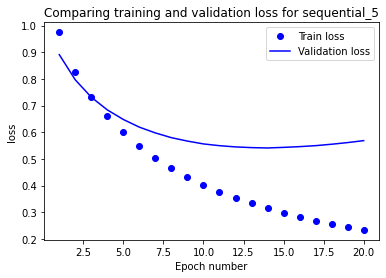

In [23]:
#1. Reduce the network's capacity (train on fewer parameters)
#This code will produce an underfit model
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
print(reduced_model.summary())
reduced_history = deep_model(reduced_model, X_trainf, y_trainf, X_val, y_val)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

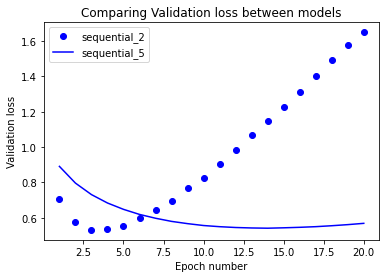

In [24]:
#We'll now compare the validation loss between the above metrics
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

Epoch 1/20
21/21 [==============================] - 2s 67ms/step - loss: 1.0698 - accuracy: 0.5809 - val_loss: 0.7956 - val_accuracy: 0.6540
Epoch 2/20
21/21 [==============================] - 1s 54ms/step - loss: 0.7322 - accuracy: 0.7096 - val_loss: 0.6908 - val_accuracy: 0.7756
Epoch 3/20
21/21 [==============================] - 1s 54ms/step - loss: 0.5976 - accuracy: 0.8247 - val_loss: 0.6558 - val_accuracy: 0.7820
Epoch 4/20
21/21 [==============================] - 1s 54ms/step - loss: 0.5055 - accuracy: 0.8662 - val_loss: 0.6305 - val_accuracy: 0.7890
Epoch 5/20
21/21 [==============================] - 1s 53ms/step - loss: 0.4449 - accuracy: 0.8875 - val_loss: 0.6354 - val_accuracy: 0.7916
Epoch 6/20
21/21 [==============================] - 1s 56ms/step - loss: 0.3974 - accuracy: 0.9049 - val_loss: 0.6486 - val_accuracy: 0.7911
Epoch 7/20
21/21 [==============================] - 1s 55ms/step - loss: 0.3786 - accuracy: 0.9094 - val_loss: 0.6583 - val_accuracy: 0.7836
Epoch 8/20
21

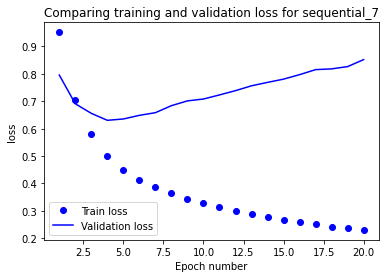

In [26]:
#2. Use Regularizatoin (here, we're going to use L2 Regularization)
#Regularization will penalize the network by adding a cost to the loss function
#for large weights, and thus will encourage a simpler model
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_history = deep_model(reg_model, X_trainf, y_trainf, X_val, y_val)
reg_min = optimal_epoch(reg_history)
eval_metric(reg_model, reg_history, 'loss')

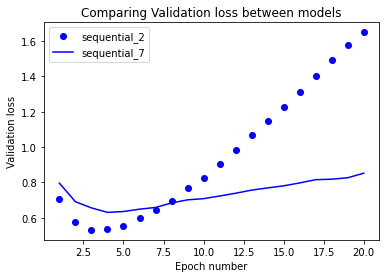

In [27]:
#We'll now comare our base model to our regularized model
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

Epoch 1/20
21/21 [==============================] - 2s 67ms/step - loss: 1.0464 - accuracy: 0.4795 - val_loss: 0.8289 - val_accuracy: 0.6219
Epoch 2/20
21/21 [==============================] - 1s 55ms/step - loss: 0.7964 - accuracy: 0.6532 - val_loss: 0.6930 - val_accuracy: 0.7129
Epoch 3/20
21/21 [==============================] - 1s 53ms/step - loss: 0.6620 - accuracy: 0.7355 - val_loss: 0.6007 - val_accuracy: 0.7761
Epoch 4/20
21/21 [==============================] - 1s 52ms/step - loss: 0.5485 - accuracy: 0.8039 - val_loss: 0.5587 - val_accuracy: 0.7906
Epoch 5/20
21/21 [==============================] - 1s 52ms/step - loss: 0.4859 - accuracy: 0.8302 - val_loss: 0.5467 - val_accuracy: 0.7949
Epoch 6/20
21/21 [==============================] - 1s 52ms/step - loss: 0.4309 - accuracy: 0.8529 - val_loss: 0.5391 - val_accuracy: 0.7981
Epoch 7/20
21/21 [==============================] - 1s 51ms/step - loss: 0.3866 - accuracy: 0.8641 - val_loss: 0.5460 - val_accuracy: 0.7965
Epoch 8/20
21

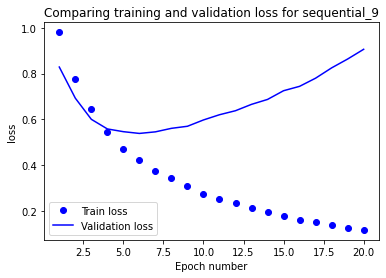

In [29]:
#3. Add Dropout layers (dropout layers set some output features to zero)
#This reduces the complexity of the model
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_history = deep_model(drop_model, X_trainf, y_trainf, X_val, y_val)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

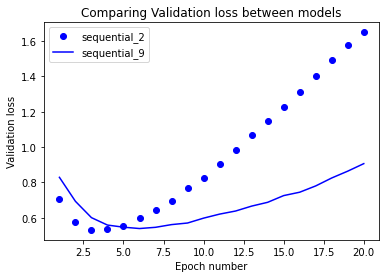

In [30]:
#Again, we'll compare our base model (sequential_2) to our dropout model
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

In [31]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

69/69 [==============================] - 0s 3ms/step - loss: 1.0262 - accuracy: 0.7482

Test accuracy: 74.82%
69/69 [==============================] - 0s 2ms/step - loss: 0.6225 - accuracy: 0.7901

Test accuracy: 79.01%
69/69 [==============================] - 0s 4ms/step - loss: 0.7216 - accuracy: 0.7819

Test accuracy: 78.19%
69/69 [==============================] - 0s 3ms/step - loss: 0.7873 - accuracy: 0.7828

Test accuracy: 78.28%
